# BigQuery Studio Notebook Tutorial to Generate customer clusters followed by a Marketing Campaign

## Overview:

**BigQuery Studio** provides a single, unified interface for all data practitioners of various coding skills to simplify analytics workflows from data preparation to data exploration and visualization to machine learning (ML) model creation and use.

Within the BigQuery Studio workspace, users find a SQL and a Colab notebook interface, an AI-powered collaborator for contextual chat and code assistance as well as source control to analytics assets including SQL scripts, Python scripts, notebooks and SQL pipelines

**BigQuery DataFrames** provides a Pythonic DataFrame and ML API powered by the BigQuery engine. The operations happen in BigQuery at scale.

*   [bigframes.pandas](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.dataframe.DataFrame) provides a pandas-compatible API for analytics.
*   [bigframes.ml](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.cluster) provides a scikit-learn-like API for ML.
*   [bigframes.ml.llm](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.llm) provides LLM capabilities.

BigQuery DataFrames is an open-source Python package. It is pre-installed on  BigQuery Studio Python notebooks.  Additionally, you can always run `pip install --upgrade bigframes` to install the latest version.



## Objectives:

This example illustrates the Data to AI journey from data exploration to constructing a k-means machine learning model with BigFrames. Subsequently, Generative AI is applied to leverage cluster information to activate marketing campaigns.

In this lab activity, you will:

* Generate features using BigQuerySQL
* Perform basic data exploration
* Implement a k-means clustering model with BigFrames
* Produce cluster descriptive statistics
* Utilize Generative AI to articulate ML model outputs in natural language for business users
* (Bonus) Use Generative AI to craft engaging emails tailored to customer segments.




###Helpful Links

* [BigFrames API Reference](https://cloud.google.com/python/docs/reference/bigframes/latest)


* [BigFrames GitHub page with sample notebooks](https://github.com/googleapis/python-bigquery-dataframes)

* [Troubleshooting notebook runtimes](https://cloud.google.com/colab/docs/troubleshooting)


## Getting Started : Setup Steps

Importing basic libraries, including authenticating the user

## Install Vertex AI SDK
Restart the kernel after the initial install

In [1]:
!pip install google-cloud-aiplatform --upgrade --user

In [2]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
from typing import Union
import sys

auth.authenticate_user()

## Define notebook variables

Please update varaibles like your GCP Project ID (`project_id`), dataset name (`dataset_name`), and location (`location`).

The variables `table_name` and `model_name` are pre-populated, but you can update them if you wish.

Ensure that the dataset exists in the same GCP Project as `project_id`.

In [3]:
#@title Setup Project Variables { run: "auto", display-mode: "form" }
project_id = "\u003C>" #@param {type:"string"}
dataset_name = "theLook_retail" #@param {type:"string"}
table_name="customer_stats" #@param {type:"string"}
model_name = "bqdf_customer_segment_cluster" #@param {type:"string"}
eval_name = model_name + "_eval"
LOCATION = "us-central1"  # @param {type:"string"}
client = bigquery.Client()



---



## Basic Exploratory Data Analysis
To kick things off, let's first inspect our data prior to constructing any models. Within this tutorial, we'll be working with the [theLook eCommerce public dataset](https://console.cloud.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce).

TheLook is an imaginary eCommerce apparel website. Within this dataset, you'll discover details about customers, products, orders, logistics, web events, and digital marketing campaigns. Our main emphasis is the `order_items` table, which contains transactional insights about customers. It's important to note that the contents of this dataset are artificially generated and are made available to professionals in the industry for the purposes of product exploration, testing, and assessment.

There are a few ways we can query data and get it into a dataframe. Here are two approaches:

#### Python

Use the Python SDK to bring data into a dataframe.

In [4]:
query = """
SELECT
  user_id,
  order_id,
  sale_price,
  created_at as order_created_date
FROM `bigquery-public-data.thelook_ecommerce.order_items`
WHERE created_at BETWEEN '2022-01-01' AND '2023-01-01'
"""
df = client.query(query).to_dataframe()
df.head()


,user_id,order_id,sale_price,order_created_date
0,75851,95036,2.5,2022-05-05 08:34:54+00:00
1,95144,119255,3.0,2022-05-22 03:05:22+00:00
2,35368,44449,3.0,2022-08-01 10:36:07+00:00
3,24102,30427,3.0,2022-10-17 01:18:45+00:00
4,52492,65873,3.0,2022-06-07 11:23:33+00:00


#### SQL
We can use the %%bigquery magic operator to run SQL directly in this notebook. Results can be sent to dataframes too. In this case, we define `df_bq` as the dataframe name.

In [5]:
%%bigquery df_bq

SELECT
  user_id,
  order_id,
  sale_price,
  created_at as order_created_date
FROM `bigquery-public-data.thelook_ecommerce.order_items`
WHERE created_at BETWEEN '2022-01-01' AND '2023-01-01'

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
df_bq.head()

,user_id,order_id,sale_price,order_created_date
0,75851,95036,2.5,2022-05-05 08:34:54+00:00
1,95144,119255,3.0,2022-05-22 03:05:22+00:00
2,35368,44449,3.0,2022-08-01 10:36:07+00:00
3,24102,30427,3.0,2022-10-17 01:18:45+00:00
4,52492,65873,3.0,2022-06-07 11:23:33+00:00


## Create features for k-means model.

The table includes recency, frequency, and monetary value metrics to provide a an understanding of customer behavior.

In [7]:

query= f"""
CREATE OR REPLACE TABLE `{project_id}.{dataset_name}.{table_name}` AS
SELECT
  user_id,
  --RECENCY
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) as days_since_last_order,
  -- FREQUENCY
  count(order_id) as count_orders,
  -- MONETARY
  AVG(sale_price) as average_spend,
  FROM
  (
SELECT user_id,
order_id,
sale_price,
created_at as order_created_date
FROM
  `bigquery-public-data.thelook_ecommerce.order_items`
WHERE created_at BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY
user_id;
"""

client.query(query)

QueryJob<project=analytics-ml-ai, location=US, id=8f9b2e7c-fa2f-444a-a3f5-b777da39bb2b>

## Create a k-means model to cluster ecommerce data

K-means is a widely used clustering algorithm that can dentify distinct groups or clusters within a dataset. With eCommerce data, k-means can segment customers, products, or transactions into meaningful groups for various analytical and business purposes.

We will assess two approaches for constructing k-means models and customer clusters:


*   one utilizing the innovative BigFrames,  pandas-like API on top of BigQuery
*   the other employing BigQuery ML


Cluster our data using ***BigFrames*** and ***BigQuery ML***!

#### Use BigQuery Dataframes to import the data

In [8]:
import bigframes.pandas as bpd
from google.cloud import bigquery

# Create a BigQuery Dataframe
df_customer = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")

## Create K-Means Model with BigFrames

In [9]:
##############################
# Generate K-Means Clusters
##############################
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

# Split test and training data
df_customer = df_customer.dropna()
train_X, test_X = train_test_split(df_customer, test_size = 0.2)
train_X = train_X.drop(columns = ["user_id"])
# Create a K-Means cluster model
kmeans = KMeans(n_clusters = 5)
kmeans.fit(train_X)
# Save the model to BigQuery
kmeans.to_gbq(f"{project_id}.{dataset_name}.{model_name}", True)

KMeans(n_clusters=5)

## (OPTIONAL) Create K-Means Model with BigQuery ML

**Note:** Uncomment the cells and verify the dataset and table name accuracy. Run the model using simple SQL!

In [10]:
# %%bigquery

# CREATE OR REPLACE MODEL `<DATASET_NAME>.bqml_customer_segment_cluster`
# OPTIONS (
#   MODEL_TYPE = "KMEANS",
#   NUM_CLUSTERS = 5,
#   KMEANS_INIT_METHOD = "KMEANS++",
#   STANDARDIZE_FEATURES = TRUE )
# AS (
# SELECT * EXCEPT (user_id)
# FROM `<DATASET_NAME>.customer_stats`
# );

## Visualize the clusters

Next we'll visualize the k-means clusters on a scatterplot. We'll chart `days_since_last_order` by `average_spend` and color by segment/cluster_id generated from the model.

Text(0.5, 1.0, 'Attribute Grouped by K-means Cluster')

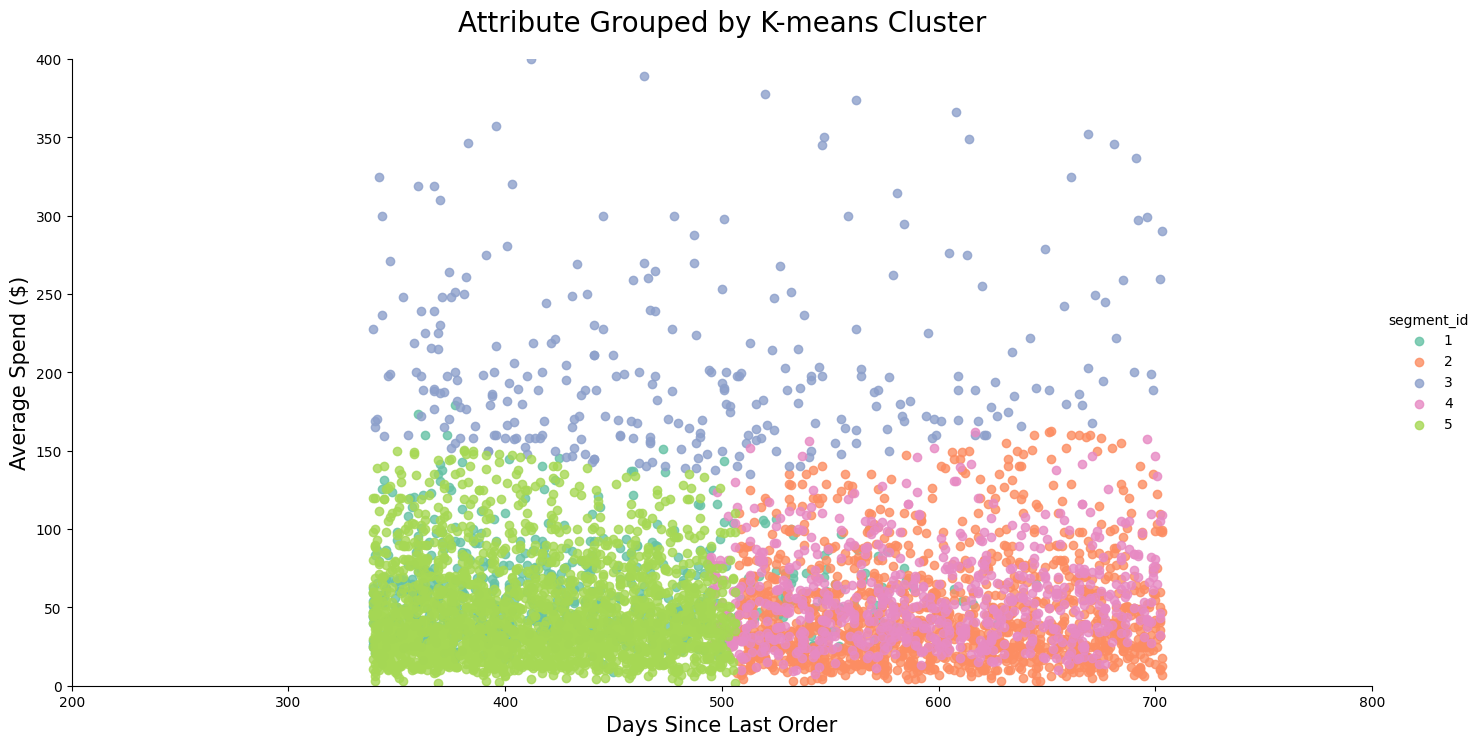

In [11]:
#########################
#Plot K-Means clusters
#########################
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Import K-Means predictions to dataframe
segments_df = kmeans.predict(df_customer).join(df_customer)
segments_df = segments_df.rename(columns={'CENTROID_ID': 'segment_id'})
segments_pd = segments_df.sample(frac=0.2, random_state=1).to_pandas()

# Generate scatterplot to display clusters
g = sns.lmplot(x='days_since_last_order', y='average_spend', data=segments_pd, fit_reg=False, hue='segment_id', palette='Set2', height=7, aspect=2)
g = (g.set_axis_labels('Days Since Last Order','Average Spend ($)', fontsize=15).set(xlim=(200,800),ylim=(0,400)))
plt.title('Attribute Grouped by K-means Cluster', pad=20, fontsize=20)

### Cluster Summary Statistics

The visualization helped us see distinct clusters. Now let's generate some summary statistics around order recency, frequency, and spend by cluster.

In [12]:
query = """
SELECT
  CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
  average_spend,
  count_orders,
  days_since_last_order
FROM (
  SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
  FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
  SUM(value)
  FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,58.07,3.95,427.11
1,cluster 2,46.96,1.00,601.92
2,cluster 3,234.61,1.27,491.29
3,cluster 4,54.43,2.42,592.65
4,cluster 5,47.78,1.30,415.79


Whew! That's a lot of metrics and cluster info. How about we explain this to our colleagues using the magic of LLMs.

Let's begin by creating a string with the summary statistics from the last cell.

In [13]:
df = client.query(query).to_dataframe()
df.to_string(header=False, index=False)

cluster_info = []
for i, row in df.iterrows():
  cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
    .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

print(str.join("\n", cluster_info))

cluster 1, average spend $58.07, count of orders per person 3.95, days since last order 427.11
cluster 2, average spend $46.96, count of orders per person 1.0, days since last order 601.92
cluster 3, average spend $234.61, count of orders per person 1.27, days since last order 491.29
cluster 4, average spend $54.43, count of orders per person 2.42, days since last order 592.65
cluster 5, average spend $47.78, count of orders per person 1.3, days since last order 415.79


# Generative AI : Explain with Vertex AI PaLM API

Install the Python library to access Vertex AI Large Language Models.

In [14]:
from google.cloud import aiplatform
from vertexai.language_models._language_models import TextGenerationModel, ChatModel

aiplatform.init(project=project_id, location=LOCATION)

For each cluster, ask the LLM to act as a brand strategist and generate the following:
* Title
* Persona
* Next Marketing Step

In [15]:
model = TextGenerationModel.from_pretrained("text-bison@001")

clusters = str.join("\n", cluster_info)

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step.

Clusters:
{clusters}

For each Cluster:
* Title:
* Persona:
* Next Marketing Step:
"""

print(model.predict(
    prompt,
    max_output_tokens=1024,
    temperature=0.55,
    top_p=0.8,
    top_k=40,
))

MultiCandidateTextGenerationResponse(text="**Cluster 1**\n\n* Title: The Loyal Customers\n* Persona: These are your most valuable customers. They spend a lot of money on your products and services, and they come back time and time again.\n* Next Marketing Step: Keep up the good work! Make sure you're always providing them with the best possible products and services, and keep them engaged with your brand through email marketing, social media, and other channels.\n\n**Cluster 2**\n\n* Title: The Occasional Buyers\n* Persona: These are customers who don't buy from you very often, but when they do, they spend a decent amount of money.\n* Next Marketing Step: Try to get these customers to buy from you more often. You can do this by sending them targeted email marketing campaigns, offering them special discounts, or running loyalty programs.\n\n**Cluster 3**\n\n* Title: The Big Spenders\n* Persona: These are customers who spend a lot of money on your products and services, but they don't bu

**Voila! We've now used k-Means clustering to create groups of spenders and explain their profiles.**



---



### BONUS #1: LLM Prompt Engineering

Sometimes, though, you want a little bit extra.

Think about using Generative AI to also generate personalized marketing emails using witty e-mail headline for marketing campaign targeted to their clusters of customers

Reference: [Prompt Generation with Generative AI](https://cloud.google.com/blog/transform/prompt-debunking-five-generative-ai-misconceptions).

In [16]:
model = TextGenerationModel.from_pretrained("text-bison@001")

cluster_info = str.join('\n', cluster_info)

prompt = f"""
Pretend you're a creative strategist, analyse the following clusters and come up with \
creative brand persona for each that includes the detail of which Taylor Swift song is \
likely to be their favorite, a summary of how this relates to their purchasing behavior, \
and a witty e-mail headline for marketing campaign targeted to their group using \
their predicted favorite song title.

Clusters:
{cluster_info}


For each Cluster:
* Cluster:
* Interests:
* Favorite Taylor Swift Song:
* Witty email headline:
* Email body:

"""

print(model.predict(
    prompt,
    max_output_tokens=1024,
    temperature=0.45,
    top_p=0.8, top_k=40,
))

MultiCandidateTextGenerationResponse(text='**Cluster 1**\n\n* Interests: Fashion, music, travel\n* Favorite Taylor Swift Song: "Blank Space"\n* Witty email headline: "You\'re the only one who can tame this blank space."\n* Email body:\n\nWe know you\'re a fan of Taylor Swift, and we think you\'d love our new collection of clothes inspired by her music. From the flirty dresses in "Blank Space" to the edgy leather jackets in "Bad Blood," we have something for everyone. Shop now and get 20% off your first order!\n\n**Cluster 2**\n\n* Interests: Books, movies, art\n* Favorite Taylor Swift Song: "All Too Well"\n* Witty email headline: "We\'re all about that long, slow burn."\n* Email body:\n\nWe know you\'re a fan of Taylor Swift\'s more introspective songs, and we think you\'ll love our new collection of books, movies, and art inspired by her music. From the classic novel "The Great Gatsby" to the iconic film "The Notebook," we have something for everyone who loves a good love story. Shop 

#### BONUS #2: Generate Python in your Notebook

If you have Duet AI enabled on your project, you can begin to generate Python directly within your Notebook:
* Open a new Code cell
* Click "Generate with AI"
* Paste one of the prompts below and hit Enter
* Generate Python code should appear in the cell


In [17]:
# prompt: 10 random numbers using numpy


In [18]:
# prompt: generate a bigframes dataframe from the table bigquery-public-data.thelook_ecommerce.order_items

In [19]:
# prompt: write some sql that queries the table bigquery-public-data.thelook_ecommerce.order_items.  Don't use python. Use %%bigquery.